In [1]:
import gym
import numpy as np

from tqdm import trange

env = gym.make('Pendulum-v0')

The pendulum challenge is to keep a 
frictionless pendulum standing up

# The Pendulum

## States

| Num | Observation |
|:-:|:-:|
| 0 | cos(theta) |
| 1 | sin(theta) |
| 2 | theta dot |


<style>
td {
  font-size: 100px
}
    
    
</style>


In [2]:
print(f"The shape of the state space: {env.observation_space.shape}")
print(f"Highest value: {env.observation_space.high}")
print(f"Lowest value: {env.observation_space.low}")

env.observation_space

print(f"A sample state: {env.observation_space.sample()}")

The shape of the state space: (3,)
Highest value: [1. 1. 8.]
Lowest value: [-1. -1. -8.]
A sample state: [ 0.32241717 -0.43231368 -4.676502  ]


## Actions

| Num | Action |
|:-:|:-:|
| 0 | Joint effort |

In [3]:
print(f"The shape of the action space: {env.action_space.shape}")
print(f"Highest value: {env.action_space.high}")
print(f"Lowest value: {env.action_space.low}")

env.action_space.seed(473)

print(f"A sample action: {env.action_space.sample()}")

The shape of the action space: (1,)
Highest value: [2.]
Lowest value: [-2.]
A sample action: [-0.8608973]


In [4]:
env.action_space.sample()

array([1.8785995], dtype=float32)

## Reward

Function: $-(theta^2 + 0.1*thetaDot^2 + 0.001*action^2)$

# The Agent

In [5]:
import sys
import numpy as np
import pandas as pd
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

### Utils

In [6]:
# Utils
class ScoreEvaluator:
    def __init__(self, window: int):
        self.window = window
        self.best_score = -np.inf
        self.avg_scores = []
        self.tmp_scores = deque(maxlen=window)
        self.last_score = None
        
    def add(self, score: float):
        if not score:
            raise ValueError(f'Score could not be {score}')
         
        self.tmp_scores.append(score)
        
        if score > self.best_score:
            self.best_score = score
        
        self._update_avg()
        self.last_score = score
        
    def plot_avg_scores(self):
        plt.plot(np.linspace(0,
                             len(self.avg_scores),
                             len(self.avg_scores),
                             endpoint=False),
                 np.asarray(self.avg_scores))
        plt.title(f'Best Reward: {self.best_score:10.5f}')
        plt.xlabel('Episode Number')
        plt.ylabel(f'Average Actions made (Over Next {self.window} Episodes)')
        rolling_mean = (pd.Series(self.avg_scores)
                          .rolling(199)
                          .mean())
        plt.plot(rolling_mean);
        
        plt.show()
        
    def _update_avg(self):
        if len(self.tmp_scores) < self.tmp_scores.maxlen:
            return
        self.avg_scores.append(np.mean(self.tmp_scores))
        
def print_iteaction(iteraction: int, score_eval: ScoreEvaluator):
    "function responsible to print some infos each iteration"
    print("{:4d} - Best Score: {:5.2f} - {:5.2f}".format(iteraction,
                                                         score_eval.best_score,
                                                         score_eval.last_score),
          end="\r",
          flush=True)

### Dummy Agent

In [7]:
class DummyAgent:
    def __init__(self):
        pass
    
    def act(self, state):
        return [np.random.normal(0., .8)]


### Policy-based Agent

In [24]:
class PolicyAgent():
    def __init__(self, env):
        # Task (environment) information
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        
        self.action_high = env.action_space.high
        self.action_low = env.action_space.low
        self.action_range = self.action_high - self.action_low

        self.w = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range / 4))
        
        self.w2 = np.random.normal(
            size=(self.state_size, self.action_size),
            scale=(self.action_range / 100))

        # Score tracker and learning parameters
        self.best_w1 = None
        self.best_w2 = None
        
        self.best_score = -np.inf
        
        self.noise = 1

        # Episode variables
        self.reset_episode()
        
        self.find_better = 1

    def reset_episode(self):
        self.total_reward = 0.0
#         self.count = 0
#         state = self.env.reset()
#         return state

    def step(self, next_state, reward, done):
        self.total_reward += reward
#         self.count += 1

        if done:
            self.learn()

    def act(self, state):
        mean = np.dot(state, self.w)
        std = np.abs(np.dot(state, self.w2))
        return np.random.normal(mean, scale=std)

    def learn(self):
#         self.score = self.total_reward / float(self.count) if self.count else 0.0
        ref = 1/(1*self.find_better)
    
        if self.total_reward > self.best_score:
            self.best_score = self.total_reward
            self.best_w = self.w
            self.best_w2 = self.w2
            self.noise = ref
            self.find_better += 1
        else:
            self.w = self.best_w
            self.w2 = self.best_w2
            self.noise = min(self.noise/10, ref/100000)
            
        #    self.noise_scale = min(2.0 * self.noise_scale, 3.2)
        self.w = self.w + self.noise * np.random.normal(size=self.w.shape,
                                               scale=self.action_range / 4)
        self.w2 = self.w2 + self.noise * np.random.normal(size=self.w.shape,
                                               scale=self.action_range / 100)

### Training

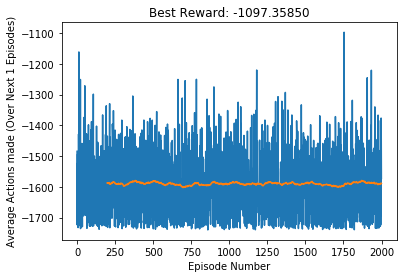

5

In [25]:
num_episodes = 2000

agent = PolicyAgent(env)

best_score = -np.inf

avg_scores = deque(maxlen=num_episodes)

score_eval = ScoreEvaluator(1)

for i in range(num_episodes):  
    score = 0
    state = env.reset()
    agent.reset_episode()
    
    while True:
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        
        agent.step(state, reward, done)
        
        score += reward
        if done:
            score_eval.add(score)
            print_iteaction(i, score_eval)
            break
            
score_eval.plot_avg_scores()

agent.find_better

In [26]:
state = env.reset()
    
while True:
    env.render()
    agent.reset_episode()
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break
        
env.close()